<a href="https://colab.research.google.com/github/gaellequillaud/Molecular_Property_Prediction_GNN/blob/main/Molecular_Property_Prediction_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Molecular Property Prediction Using Graph Neural Networks**


## **1. Install RDkit and PyTorch Geometric**



In [ ]:
! pip install rdkit
! pip install torch_geometric

## **2. Solubility dataset**

The original [Delaney's dataset](https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt). The full paper is entitled [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x).$^1$

### **2.1. Download the dataset**

In [ ]:
! wget https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt

If the previous link doesn't work, use :

In [ ]:
! wget https://raw.githubusercontent.com/gaellequillaud/Molecular_Property_Prediction_GNN/main/delaney.csv

### **2.2. Read in the dataset**

---

In [5]:
import pandas as pd

In [ ]:
sol = pd.read_csv('delaney.csv')
sol

## **3. Calculate molecular descriptors in RDKit**

### **3.1. Convert list of molecules to rdkit object**

In [8]:
from rdkit import Chem

In [12]:
mol_list = [Chem.MolFromSmiles(element) for element in sol.SMILES]

In [13]:
len(mol_list)

1144

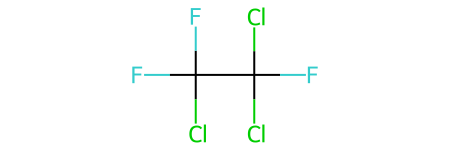

In [19]:
mol_list[4]

# Data preprocessing

## Preprocessing ?

## Conversion from SMILES to RDKit to Graph


In [61]:
import torch
import torch_geometric.utils as pyg_utils
from rdkit import Chem

In [62]:
def smiles_to_graph(smiles, label):
    """
    Convert SMILES representation of a molecule into a PyTorch Geometric Data object.

    Args:
    - smiles (str): SMILES representation of the molecule
    - label (int): Label for the molecule

    Returns:
    - PyTorch Geometric Data object representing the molecule with label
    """
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    # Create an empty graph
    num_nodes = mol.GetNumAtoms()
    edge_index = []
    x = []  # Node features
    for i, atom in enumerate(mol.GetAtoms()):
        atom_features = [
            atom.GetAtomicNum(),
            atom.GetFormalCharge(),
            atom.GetTotalNumHs(),
            # Add more features as needed
        ]
        x.append(atom_features)

        # Add edges for bonds
        for bond in atom.GetBonds():
            j = bond.GetOtherAtomIdx(i)
            edge_index.append([i, j])

    # Convert to PyTorch tensors
    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor(label, dtype=torch.long)  # Convert label to tensor

    return Data(x=x, edge_index=edge_index, y=y)

# Graph Neural Network

In [63]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

## Model

In [64]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply graph convolutional layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [65]:
dataCCO = smiles_to_graph("CCO", 1)
# Define the dimensions for the input, hidden, and output layers
input_dim = len(dataCCO.x[0])
hidden_dim = 64
output_dim = 2  # Number of classes (for classification task)

# Instantiate the GCN model
model = GCN(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [84]:
smiles_list = [["CCO", 1], ["CN=C=O", 1], ["C1=CC1", 0], ["CCC(=O)O", 0], ["N#N", 1], ["[Cu+2].[O-]S(=O)(=O)[O-]", 0]]
dataset = [smiles_to_graph(smiles, label) for smiles, label in smiles_list]
print(dataset)

[Data(x=[3, 3], edge_index=[2, 4], y=1), Data(x=[4, 3], edge_index=[2, 6], y=1), Data(x=[3, 3], edge_index=[2, 6], y=0), Data(x=[5, 3], edge_index=[2, 8], y=0), Data(x=[2, 3], edge_index=[2, 2], y=1), Data(x=[6, 3], edge_index=[2, 8], y=0)]


## DataLoaders

In [67]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.data import Dataset
from torch_geometric.data import Batch

In [82]:
# Assuming you have a list of PyTorch Geometric Data objects representing your molecules
# You may need to load your data and convert it into PyTorch Geometric Data objects first

# Split the dataset into train and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

def custom_collate(batch):
    return Batch.from_data_list(batch)

# Define batch size
batch_size = 32

# Create DataLoader instances for train and test sets using the custom collate function
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

## Training

In [83]:
# Train the GCN model (you need to define your training loop)
# For simplicity, let's assume 'train_loader' is your DataLoader for training data
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

ValueError: Expected input batch_size (16) to match target batch_size (4).

## Evaluation

In [ ]:
# Evaluate the GCN model (you need to define your evaluation loop)
# For simplicity, let's assume 'test_loader' is your DataLoader for test data
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        out = model(batch)
        _, predicted = torch.max(out, 1)
        total += batch.y.size(0)
        correct += (predicted == batch.y).sum().item()

    accuracy = correct / total
    print('Accuracy:', accuracy)